# Tech Challenge FIAP - Etapa 6: Validação Estatística

In [ ]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn-v0_8')
np.random.seed(42)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 1. Carregamento do Dataset

Vamos carregar o dataset pré-processado que já passou pelas etapas de limpeza, transformação e feature engineering.

In [2]:
dataset_path = r"C:\Users\prado\.cache\kagglehub\datasets\awaiskaggler\insurance-csv\versions\1\insurance_preprocessed.csv"

try:
    df = pd.read_csv(dataset_path)
    print("Dataset carregado com sucesso!")
    print(f"Colunas: {list(df.columns)}")
    print("\nPrimeiras 5 linhas do dataset:")
    display(df.head())
    print("\nInformações do dataset:")
    display(df.info())
except FileNotFoundError:
    print("Arquivo não encontrado. Verifique o caminho do dataset.")
    print("Caminho esperado:", dataset_path)

Dataset carregado com sucesso!
Colunas: ['age', 'bmi', 'children', 'expenses', 'log_expenses', 'smoker_encoded', 'sex_male', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'age_bmi_interaction', 'age_squared', 'bmi_normal', 'bmi_obese', 'bmi_overweight', 'bmi_underweight', 'high_risk']

Primeiras 5 linhas do dataset:


,age,bmi,children,expenses,log_expenses,smoker_encoded,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,age_bmi_interaction,age_squared,bmi_normal,bmi_obese,bmi_overweight,bmi_underweight,high_risk
0,-1.440418,-0.453484,-0.909234,16884.92,9.734235,1,0,False,False,False,True,-1.305601,-1.221599,False,False,True,False,0
1,-1.511647,0.513986,-0.079442,1725.55,7.453880,0,1,False,False,True,False,-1.155713,-1.254484,False,True,False,False,0
2,-0.799350,0.382803,1.580143,4449.46,8.400763,0,1,False,False,True,False,-0.551569,-0.845647,False,True,False,False,0
3,-0.443201,-1.306169,-0.909234,21984.47,9.998137,0,1,False,True,False,False,-0.886375,-0.574570,True,False,False,False,0
4,-0.514431,-0.289506,-0.909234,3866.86,8.260457,0,1,False,True,False,False,-0.550037,-0.632340,False,False,True,False,0



Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1337 non-null   float64
 1   bmi                  1337 non-null   float64
 2   children             1337 non-null   float64
 3   expenses             1337 non-null   float64
 4   log_expenses         1337 non-null   float64
 5   smoker_encoded       1337 non-null   int64  
 6   sex_male             1337 non-null   int64  
 7   region_northeast     1337 non-null   bool   
 8   region_northwest     1337 non-null   bool   
 9   region_southeast     1337 non-null   bool   
 10  region_southwest     1337 non-null   bool   
 11  age_bmi_interaction  1337 non-null   float64
 12  age_squared          1337 non-null   float64
 13  bmi_normal           1337 non-null   bool   
 14  bmi_obese            1337 non-null   bool   
 15  bmi_overweigh

None

## 2. Pipeline de Modelagem para Múltiplos Targets

Vamos definir funções para executar todo o pipeline de modelagem para cada target, garantindo que não haja vazamento de informação entre features e target.

In [3]:
# Função para preparar dados, treinar modelos, realizar validação cruzada e avaliar métricas
def run_regression_pipeline(df, target_column, drop_columns, model_names=None):
    """
    Executa o pipeline de regressão para um target específico.
    - df: DataFrame de entrada
    - target_column: nome da coluna target
    - drop_columns: lista de colunas a remover das features (inclui o outro target)
    - model_names: nomes dos modelos para exibição
    Retorna: dicionário com resultados, previsões, resíduos, etc.
    """
    # Corrigido: garantir que a coluna target não está nas features
    X = df.drop(columns=drop_columns + [target_column] if target_column not in drop_columns else drop_columns)
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    }
    if model_names:
        models = dict(zip(model_names, models.values()))

    predictions = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions[name] = model.predict(X_test)

    cv_folds = 5
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_results = {}
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
        cv_rmse = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
        cv_results[name] = {
            'R2_scores': cv_scores,
            'R2_mean': cv_scores.mean(),
            'R2_std': cv_scores.std(),
            'RMSE_scores': cv_rmse,
            'RMSE_mean': cv_rmse.mean(),
            'RMSE_std': cv_rmse.std()
        }

    def calculate_metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}

    results = []
    for name in models.keys():
        metrics = calculate_metrics(y_test, predictions[name])
        metrics['Modelo'] = name
        results.append(metrics)
    results_df = pd.DataFrame(results)

    best_model_idx = results_df['R²'].idxmax()
    best_model_name = results_df.loc[best_model_idx, 'Modelo']
    best_predictions = predictions[best_model_name]
    residuals = y_test - best_predictions

    return {
        'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test,
        'models': models, 'predictions': predictions, 'cv_results': cv_results,
        'results_df': results_df, 'best_model_name': best_model_name,
        'best_predictions': best_predictions, 'residuals': residuals,
        'cv_summary': pd.DataFrame({
            'Modelo': list(cv_results.keys()),
            'R² Médio': [cv_results[name]['R2_mean'] for name in cv_results.keys()],
            'R² Desvio': [cv_results[name]['R2_std'] for name in cv_results.keys()],
            'RMSE Médio': [cv_results[name]['RMSE_mean'] for name in cv_results.keys()],
            'RMSE Desvio': [cv_results[name]['RMSE_std'] for name in cv_results.keys()]
        })
    }

## 3. Modelagem para ambos os targets

Executaremos o pipeline para:
- Target 1: **expenses** (valor original)
- Target 2: **log_expenses** (transformação logarítmica)

Em cada caso, a coluna do outro target é removida das features.

In [ ]:
# expenses (target original)
print("=== Pipeline para target: expenses ===")
pipeline_expenses = run_regression_pipeline(
    df,
    target_column='expenses',
    drop_columns=['log_expenses'],
    model_names=None
)
print("Concluído para expenses.\n")

# log_expenses (target transformado)
print("=== Pipeline para target: log_expenses ===")
pipeline_log = run_regression_pipeline(
    df,
    target_column='log_expenses',
    drop_columns=['expenses'], 
    model_names=None
)
print("Concluído para log_expenses.")

=== Pipeline para target: expenses ===
Concluído para expenses.

=== Pipeline para target: log_expenses ===
Concluído para expenses.

=== Pipeline para target: log_expenses ===
Concluído para log_expenses.
Concluído para log_expenses.


## 4. Validação Cruzada e Avaliação das Métricas

Visualizaremos os resultados da validação cruzada e das métricas finais para cada target.

Validação cruzada - expenses


C:\Users\prado\AppData\Local\Temp\ipykernel_19888\2839684683.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(r2_data, labels=cv_results.keys())
C:\Users\prado\AppData\Local\Temp\ipykernel_19888\2839684683.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(rmse_data, labels=cv_results.keys())


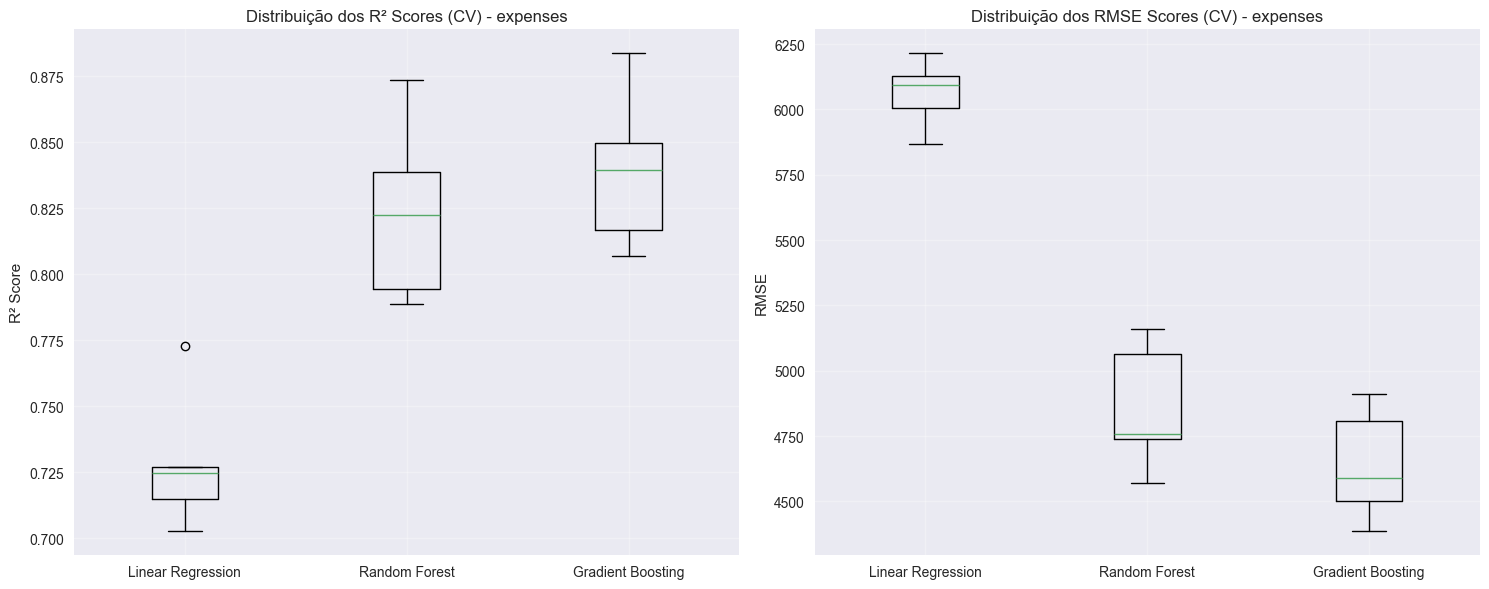

,Modelo,R² Médio,R² Desvio,RMSE Médio,RMSE Desvio
0,Linear Regression,0.7285,0.0239,6063.0535,117.7059
1,Random Forest,0.8237,0.0310,4858.5734,220.3426
2,Gradient Boosting,0.8394,0.0270,4640.0729,194.0735


,MAE,MSE,RMSE,R²,Modelo
0,4377.5529,3.685012e+07,6070.4298,0.7995,Linear Regression
1,2550.5887,2.117697e+07,4601.8437,0.8848,Random Forest
2,2518.2975,1.898583e+07,4357.2735,0.8967,Gradient Boosting


Validação cruzada - log_expenses


C:\Users\prado\AppData\Local\Temp\ipykernel_19888\2839684683.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(r2_data, labels=cv_results.keys())
C:\Users\prado\AppData\Local\Temp\ipykernel_19888\2839684683.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(rmse_data, labels=cv_results.keys())


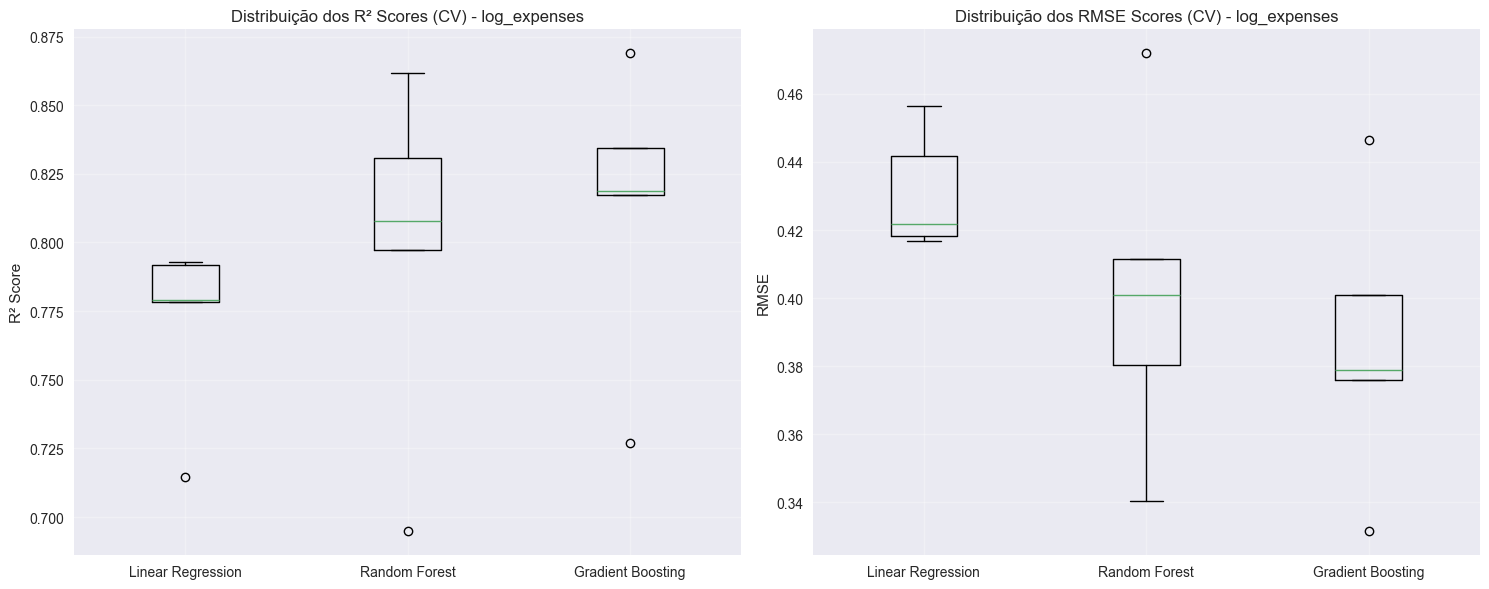

,Modelo,R² Médio,R² Desvio,RMSE Médio,RMSE Desvio
0,Linear Regression,0.7713,0.0290,0.4310,0.0155
1,Random Forest,0.7984,0.0563,0.4010,0.0429
2,Gradient Boosting,0.8133,0.0470,0.3868,0.0374


,MAE,MSE,RMSE,R²,Modelo
0,0.2477,0.1403,0.3746,0.8488,Linear Regression
1,0.1911,0.1387,0.3725,0.8505,Random Forest
2,0.1859,0.1099,0.3315,0.8816,Gradient Boosting


In [ ]:
# Plot de cross-validation
def plot_cv_results(cv_results, title_suffix):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    r2_data = [cv_results[name]['R2_scores'] for name in cv_results.keys()]
    rmse_data = [cv_results[name]['RMSE_scores'] for name in cv_results.keys()]
    ax1.boxplot(r2_data, labels=cv_results.keys())
    ax1.set_title(f'Distribuição dos R² Scores (CV) - {title_suffix}')
    ax1.set_ylabel('R² Score')
    ax1.grid(True, alpha=0.3)
    ax2.boxplot(rmse_data, labels=cv_results.keys())
    ax2.set_title(f'Distribuição dos RMSE Scores (CV) - {title_suffix}')
    ax2.set_ylabel('RMSE')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Expenses
print("Validação cruzada - expenses")
plot_cv_results(pipeline_expenses['cv_results'], 'expenses')
display(pipeline_expenses['cv_summary'].round(4))
display(pipeline_expenses['results_df'].round(4))

# Log_expenses
print("Validação cruzada - log_expenses")
plot_cv_results(pipeline_log['cv_results'], 'log_expenses')
display(pipeline_log['cv_summary'].round(4))
display(pipeline_log['results_df'].round(4))

## 5. Visualização das Métricas e Previsões

Visualize as principais métricas e a comparação entre valores reais e previstos para cada target.

Visualização das métricas - expenses


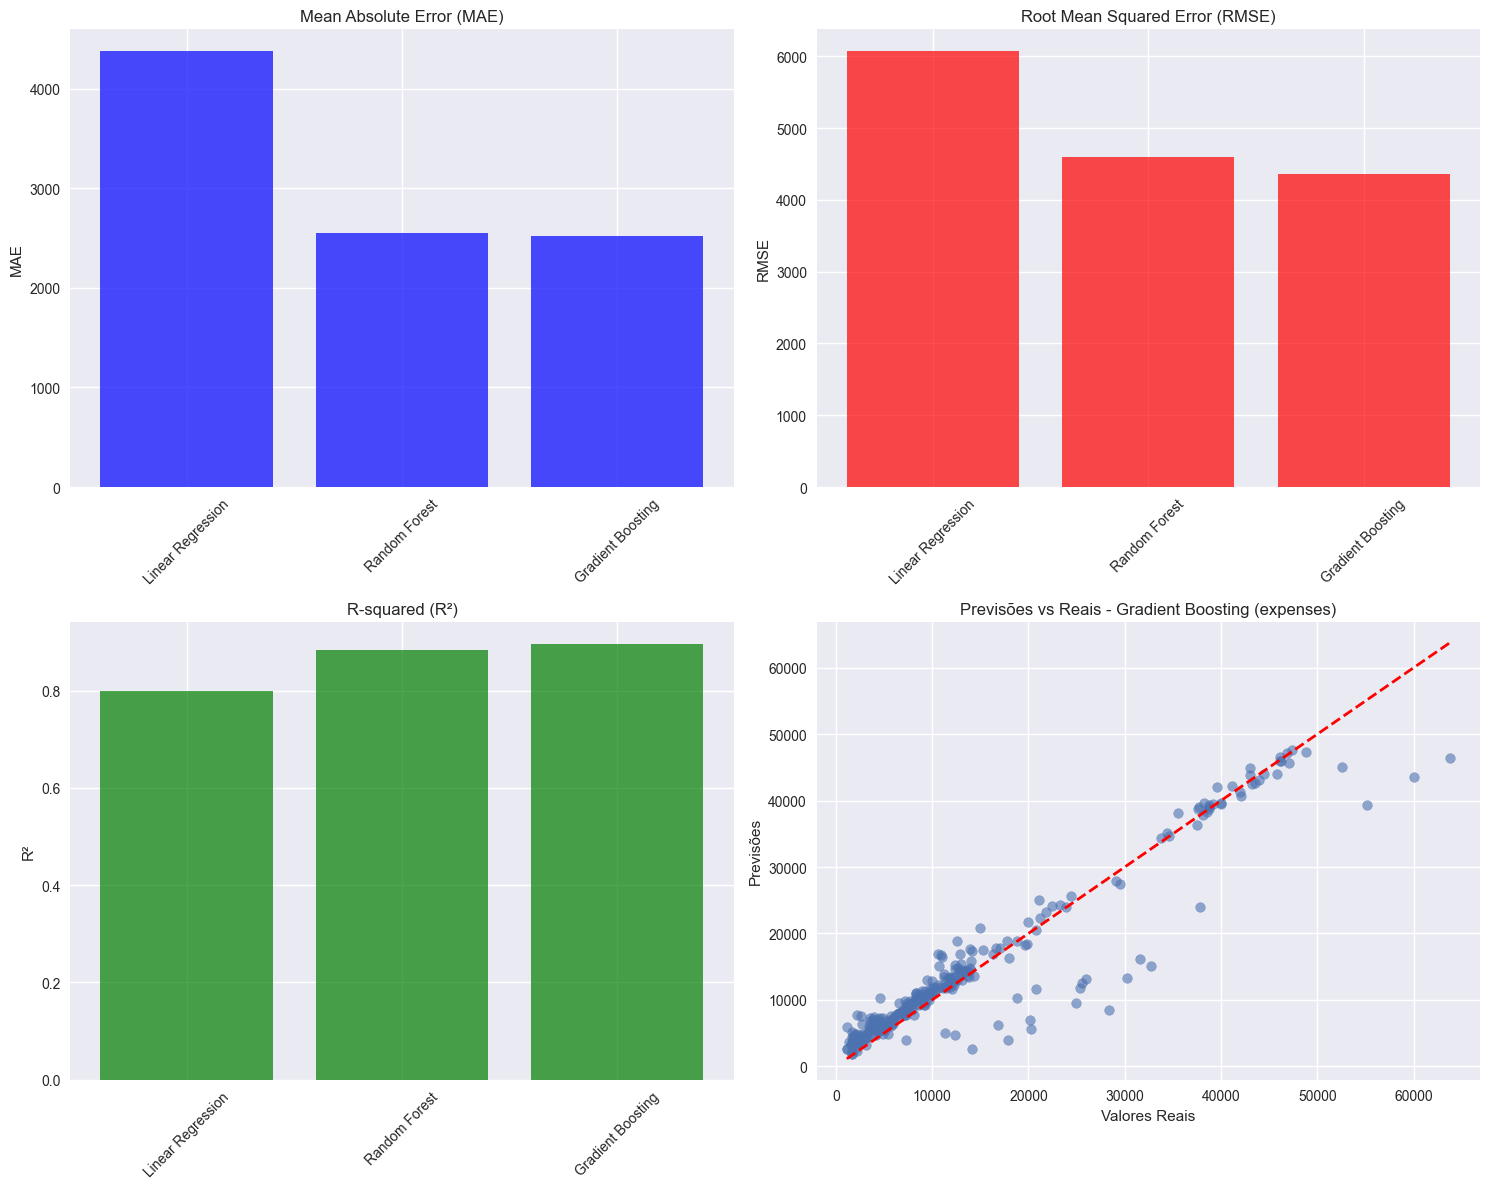


MELHOR MODELO (expenses): Gradient Boosting
R² Score: 0.8967
Visualização das métricas - log_expenses


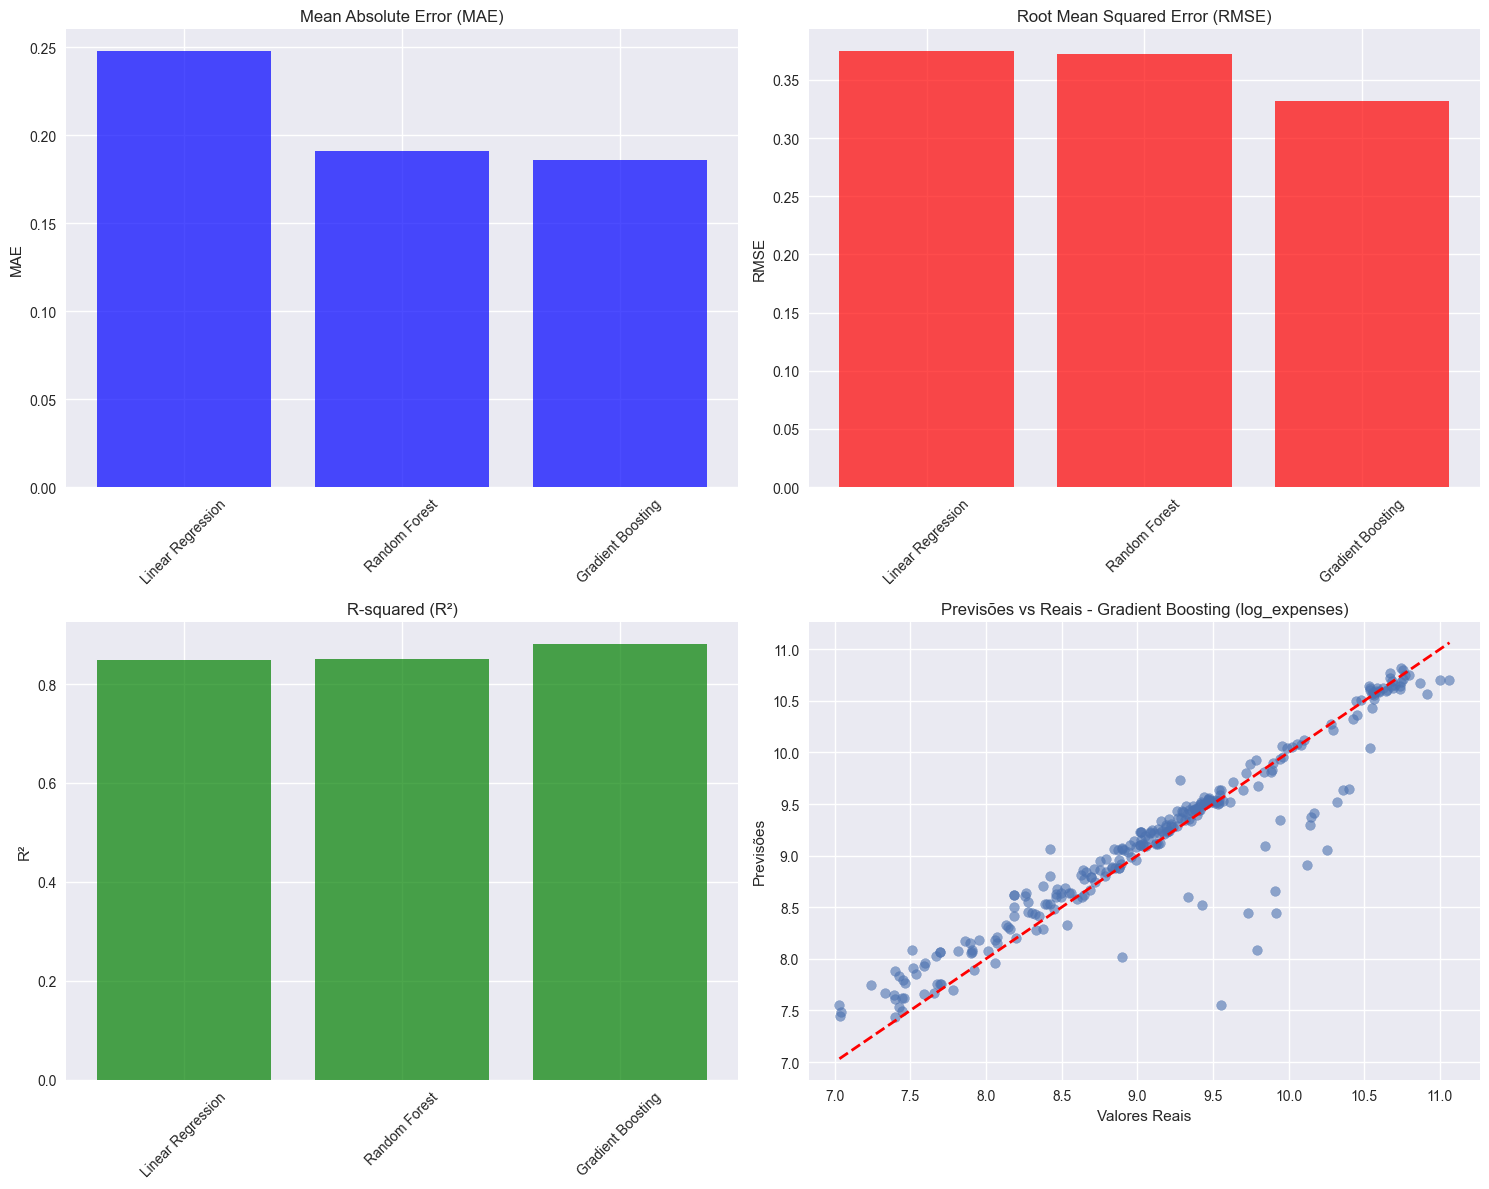


MELHOR MODELO (log_expenses): Gradient Boosting
R² Score: 0.8816


In [ ]:
# Função das métricas e previsões
def plot_metrics_and_predictions(results_df, y_test, predictions, best_model_name, best_predictions, target_label):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    models_names = results_df['Modelo']

    # MAE
    ax1.bar(models_names, results_df['MAE'], color='blue', alpha=0.7)
    ax1.set_title('Mean Absolute Error (MAE)')
    ax1.set_ylabel('MAE')
    ax1.tick_params(axis='x', rotation=45)

    # RMSE
    ax2.bar(models_names, results_df['RMSE'], color='red', alpha=0.7)
    ax2.set_title('Root Mean Squared Error (RMSE)')
    ax2.set_ylabel('RMSE')
    ax2.tick_params(axis='x', rotation=45)

    # R²
    ax3.bar(models_names, results_df['R²'], color='green', alpha=0.7)
    ax3.set_title('R-squared (R²)')
    ax3.set_ylabel('R²')
    ax3.tick_params(axis='x', rotation=45)

    # Previsões vs valores reais (melhor modelo)
    ax4.scatter(y_test, best_predictions, alpha=0.6)
    min_val = min(y_test.min(), best_predictions.min())
    max_val = max(y_test.max(), best_predictions.max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax4.set_xlabel('Valores Reais')
    ax4.set_ylabel('Previsões')
    ax4.set_title(f'Previsões vs Reais - {best_model_name} ({target_label})')

    plt.tight_layout()
    plt.show()

    print(f"\nMELHOR MODELO ({target_label}): {best_model_name}")
    print(f"R² Score: {results_df.loc[results_df['Modelo'] == best_model_name, 'R²'].values[0]:.4f}")

# Expenses
print("Visualização das métricas - expenses")
plot_metrics_and_predictions(
    pipeline_expenses['results_df'],
    pipeline_expenses['y_test'],
    pipeline_expenses['predictions'],
    pipeline_expenses['best_model_name'],
    pipeline_expenses['best_predictions'],
    target_label='expenses'
)

# Log_expenses
print("Visualização das métricas - log_expenses")
plot_metrics_and_predictions(
    pipeline_log['results_df'],
    pipeline_log['y_test'],
    pipeline_log['predictions'],
    pipeline_log['best_model_name'],
    pipeline_log['best_predictions'],
    target_label='log_expenses'
)

## 6. Análise de Resíduos

Análise dos resíduos do melhor modelo para cada target.

Análise de resíduos - expenses


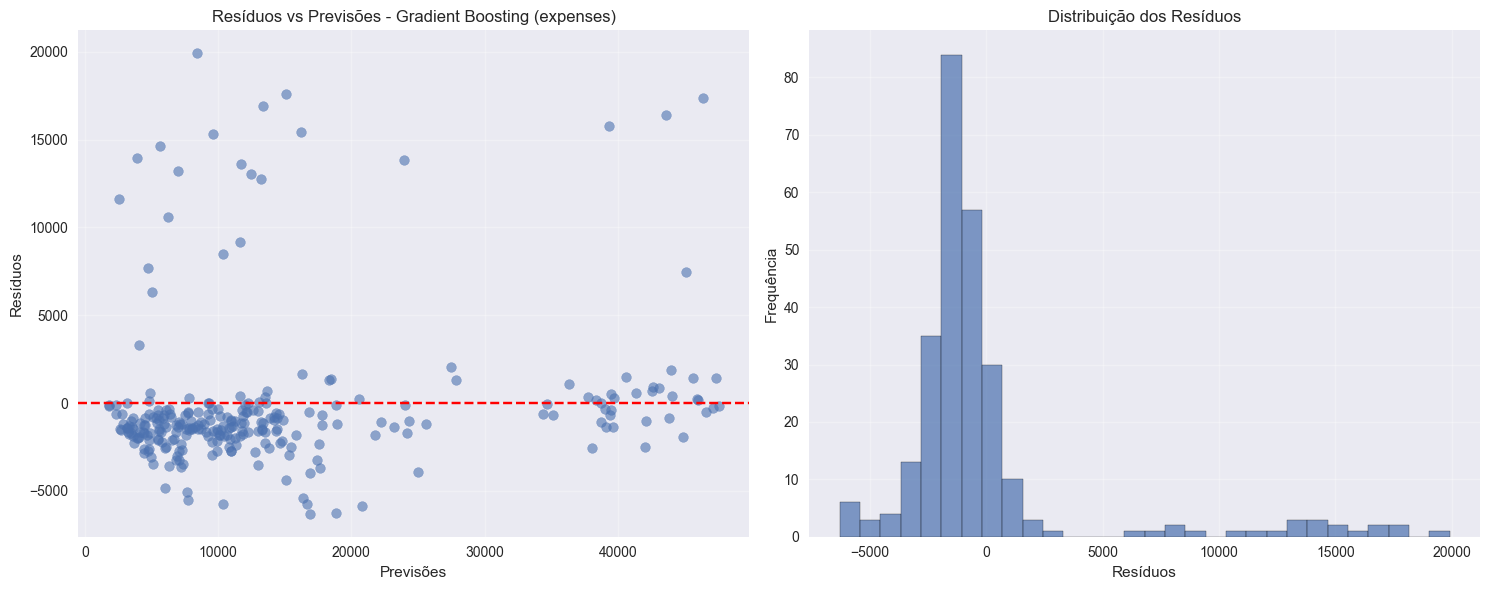


ESTATÍSTICAS DOS RESÍDUOS (Gradient Boosting - expenses):
Média: -149.896706
Desvio Padrão: 4362.8417
Mínimo: -6301.9975
Máximo: 19906.1924
Análise de resíduos - log_expenses


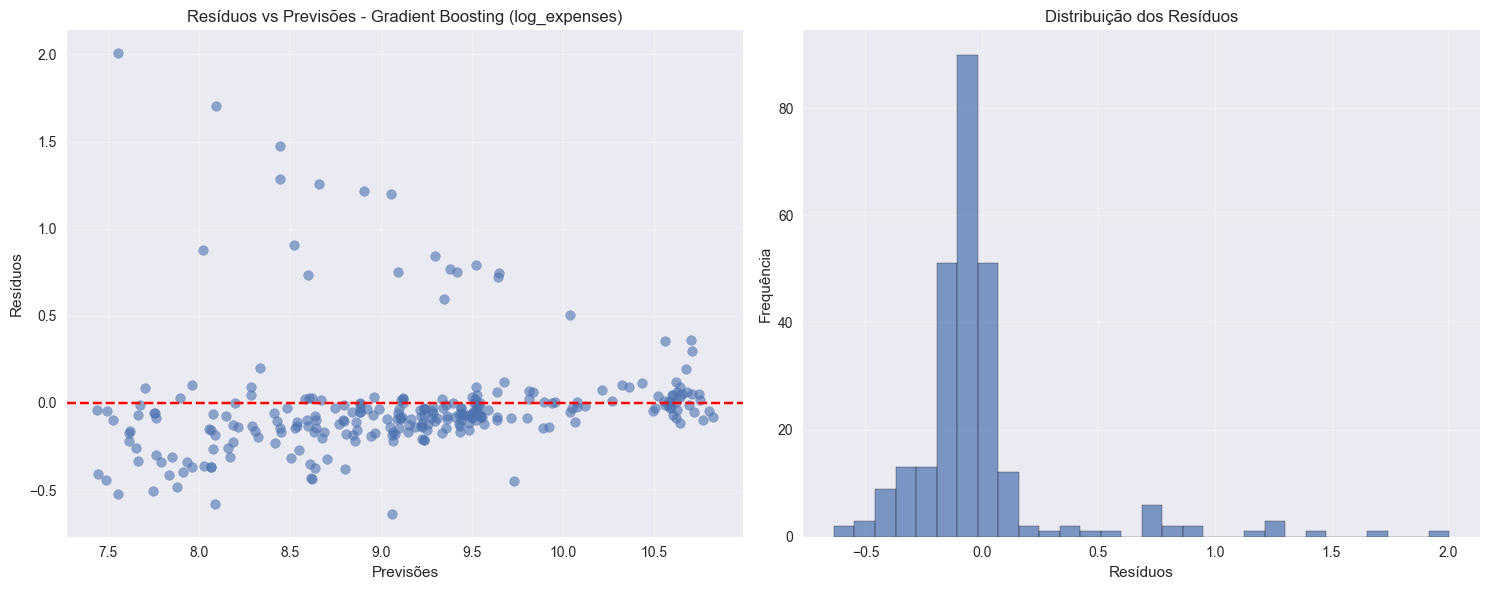


ESTATÍSTICAS DOS RESÍDUOS (Gradient Boosting - log_expenses):
Média: -0.015929
Desvio Padrão: 0.3317
Mínimo: -0.6351
Máximo: 2.0052


In [7]:
# Função para análise de resíduos
def plot_residuals(y_test, best_predictions, residuals, best_model_name, target_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    # Resíduos vs Previsões
    ax1.scatter(best_predictions, residuals, alpha=0.6)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Previsões')
    ax1.set_ylabel('Resíduos')
    ax1.set_title(f'Resíduos vs Previsões - {best_model_name} ({target_label})')
    ax1.grid(True, alpha=0.3)
    # Histograma dos resíduos
    ax2.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Resíduos')
    ax2.set_ylabel('Frequência')
    ax2.set_title('Distribuição dos Resíduos')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Estatísticas dos resíduos
    print(f"\nESTATÍSTICAS DOS RESÍDUOS ({best_model_name} - {target_label}):")
    print(f"Média: {residuals.mean():.6f}")
    print(f"Desvio Padrão: {residuals.std():.4f}")
    print(f"Mínimo: {residuals.min():.4f}")
    print(f"Máximo: {residuals.max():.4f}")

# Expenses
print("Análise de resíduos - expenses")
plot_residuals(
    pipeline_expenses['y_test'],
    pipeline_expenses['best_predictions'],
    pipeline_expenses['residuals'],
    pipeline_expenses['best_model_name'],
    'expenses'
)

# Log_expenses
print("Análise de resíduos - log_expenses")
plot_residuals(
    pipeline_log['y_test'],
    pipeline_log['best_predictions'],
    pipeline_log['residuals'],
    pipeline_log['best_model_name'],
    'log_expenses'
)

## 7. Comparação Final das Métricas dos Modelos

Tabela comparativa das principais métricas (MAE, MSE, RMSE, R²) dos modelos para cada target.

In [8]:
# Adiciona coluna de target para comparação
df_exp = pipeline_expenses['results_df'].copy()
df_exp['Target'] = 'expenses'
df_log = pipeline_log['results_df'].copy()
df_log['Target'] = 'log_expenses'
comparison_df = pd.concat([df_exp, df_log], ignore_index=True)

# Reorganiza colunas
cols = ['Target', 'Modelo', 'MAE', 'MSE', 'RMSE', 'R²']
comparison_df = comparison_df[cols]

print("Tabela comparativa das métricas dos modelos para cada target:")
display(comparison_df.round(4))

Tabela comparativa das métricas dos modelos para cada target:


,Target,Modelo,MAE,MSE,RMSE,R²
0,expenses,Linear Regression,4377.5529,3.685012e+07,6070.4298,0.7995
1,expenses,Random Forest,2550.5887,2.117697e+07,4601.8437,0.8848
2,expenses,Gradient Boosting,2518.2975,1.898583e+07,4357.2735,0.8967
3,log_expenses,Linear Regression,0.2477,1.403000e-01,0.3746,0.8488
4,log_expenses,Random Forest,0.1911,1.387000e-01,0.3725,0.8505
5,log_expenses,Gradient Boosting,0.1859,1.099000e-01,0.3315,0.8816


## 8. Validação Estatística dos Coeficientes da Regressão Linear

In [10]:
pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 9.8/9.8 MB 55.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import statsmodels.api as sm

X_train = pipeline_log['X_train']
y_train = pipeline_log['y_train']

X_train_fixed = X_train.copy()
for col in X_train_fixed.select_dtypes(include='bool').columns:
    X_train_fixed[col] = X_train_fixed[col].astype(int)

region_cols = ['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
if all(col in X_train_fixed.columns for col in region_cols):
    X_train_fixed = X_train_fixed.drop(columns=['region_southwest'])

# Adicione o intercepto
X_train_sm = sm.add_constant(X_train_fixed)

# Ajuste o modelo OLS
model_sm = sm.OLS(y_train, X_train_sm).fit()

print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:           log_expenses   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     266.2
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        00:16:18   Log-Likelihood:                -603.51
No. Observations:                1069   AIC:                             1237.
Df Residuals:                    1054   BIC:                             1312.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.9138    

In [40]:
pvalues = model_sm.pvalues
print("P-values dos coeficientes:")
print(pvalues)

P-values dos coeficientes:
const                   9.036799e-23
age                     3.523705e-01
bmi                     3.363346e-01
children                6.956382e-06
smoker_encoded         1.055857e-189
sex_male                8.048533e-01
region_northeast        1.766341e-01
region_northwest        7.272378e-01
region_southeast        9.938155e-01
age_bmi_interaction     6.830123e-01
age_squared             4.649270e-05
bmi_normal              9.733985e-02
bmi_obese               2.802122e-12
bmi_overweight          2.917772e-03
bmi_underweight         3.005624e-01
high_risk               1.395193e-01
dtype: float64


In [41]:
conf_int = model_sm.conf_int(alpha=0.05)
conf_int.columns = ['2.5%', '97.5%']
print("Intervalos de confiança dos coeficientes:")
print(conf_int)

Intervalos de confiança dos coeficientes:
                             2.5%         97.5%
const                 4317.625569   6411.692422
age                  -4460.157741   1590.943550
bmi                   -649.146399   1897.506518
children               495.860515   1257.341387
smoker_encoded       21241.720552  23650.643310
sex_male              -814.175550    632.031708
region_northeast      -323.111259   1755.217894
region_northwest      -844.960253   1210.420292
region_southeast     -1026.312231   1034.454625
age_bmi_interaction  -2762.618910   1810.620983
age_squared           2713.206173   7718.221247
bmi_normal            -167.632630   2004.589097
bmi_obese             3317.935806   5866.828857
bmi_overweight         459.858453   2227.375916
bmi_underweight      -4312.299590   1332.662082
high_risk             -434.608152   3092.859889


## 9. Análise de Multicolinearidade

Cálculo do VIF (Variance Inflation Factor) para as variáveis do modelo. Um VIF alto (> 5 ou 10) indica multicolinearidade.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = []
    for i in range(X.shape[1]):
        vif = variance_inflation_factor(X.values, i)
        vif_data.append((X.columns[i], vif))
    return pd.DataFrame(vif_data, columns=["feature", "VIF"])

X_train_log = pipeline_log['X_train'].copy()

for col in X_train_log.select_dtypes(include='bool').columns:
    X_train_log[col] = X_train_log[col].astype(int)
if all(col in X_train_log.columns for col in region_cols):
    X_train_log = X_train_log.drop(columns=['region_southwest'])

X_train_log_sm = sm.add_constant(X_train_log)
print("\nVIF para as variáveis do modelo (log_expenses):")
vif_log = calculate_vif(X_train_log_sm.drop(columns=['const']))
print(vif_log)


VIF para as variáveis do modelo (log_expenses):
                feature        VIF
0                   age  70.526430
1                   bmi  12.369744
2              children   1.104035
3        smoker_encoded   1.801641
4              sex_male   1.013056
5      region_northeast   1.513150
6      region_northwest   1.523445
7      region_southeast   1.617294
8   age_bmi_interaction  40.172408
9           age_squared  48.375612
10           bmi_normal   3.107860
11            bmi_obese   4.050318
12       bmi_overweight   2.655764
13      bmi_underweight   1.384686
14            high_risk   1.953670


## 10. Ajuste do Modelo sem Variáveis Derivadas de Alto VIF

In [80]:

cols_to_remove = ['age', 'bmi', 'sex_male', 'region_northeast', 'region_northwest', 'region_southeast', 'age_bmi_interaction', 'bmi_normal', 'bmi_overweight', 'bmi_underweight', 'high_risk']
X_train_reduced = X_train_fixed.drop(columns=cols_to_remove)

vif_reduced = calculate_vif(X_train_reduced)
print("VIF após remoção das variáveis:")
print(vif_reduced)

import statsmodels.api as sm
X_train_reduced_sm = sm.add_constant(X_train_reduced)
model_sm_reduced = sm.OLS(y_train, X_train_reduced_sm).fit()

print("\nResumo do novo modelo OLS (sem variáveis derivadas):")
print(model_sm_reduced.summary())

VIF após remoção das variáveis:
          feature       VIF
0        children  1.000399
1  smoker_encoded  1.111534
2     age_squared  1.009646
3       bmi_obese  1.116350

Resumo do novo modelo OLS (sem variáveis derivadas):
                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     753.7
Date:                Sat, 31 May 2025   Prob (F-statistic):          1.32e-308
Time:                        01:13:17   Log-Likelihood:                -10812.
No. Observations:                1069   AIC:                         2.163e+04
Df Residuals:                    1064   BIC:                         2.166e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                          

In [82]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred_train_original = model_sm.predict(X_train_sm)
y_pred_train_reduced = model_sm_reduced.predict(X_train_reduced_sm)

rmse_original = np.sqrt(mean_squared_error(y_train, y_pred_train_original))
r2_original = r2_score(y_train, y_pred_train_original)

rmse_reduced = np.sqrt(mean_squared_error(y_train, y_pred_train_reduced))
r2_reduced = r2_score(y_train, y_pred_train_reduced)

print("Comparação das métricas no conjunto de treino:")
print(f"Modelo original:     R² = {r2_original:.4f} | RMSE = {rmse_original:.2f}")
print(f"Modelo reduzido:     R² = {r2_reduced:.4f} | RMSE = {rmse_reduced:.2f}")

pvalues = model_sm_reduced.pvalues
print("P-values dos coeficientes:")
print(pvalues)

Comparação das métricas no conjunto de treino:
Modelo original:     R² = 0.7422 | RMSE = 5940.79
Modelo reduzido:     R² = 0.7391 | RMSE = 5976.18
P-values dos coeficientes:
const              1.449768e-92
children           1.446440e-05
smoker_encoded    4.086664e-283
age_squared        8.564684e-72
bmi_obese          1.237808e-26
dtype: float64
